## Data Preparation

In [1]:
# loading libraries

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from math import nan

pd.set_option('display.max_columns', None)

# loading destatis data
path = '../data/processed/combined_data.csv'
df = pd.read_csv(path)
index_list = pd.read_csv('../data/processed/index_list_combined_data.csv', names=['Datum'])
index_list.drop(index_list.index[0], inplace=True)
df.index = index_list['Datum']
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')



In [2]:
# Defining demand and price::
demand = (df.iloc[:, 45])
price = df.iloc[:, 122]

# Calculating percentage change in demand and price
demand_change = demand.pct_change()
price_change = price.pct_change()

# Calculating price elasticity of demand
df.loc[:, 'elasticity'] = demand_change / price_change
df['elasticity'] = df['elasticity'].replace([np.inf, -np.inf], np.nan)

# defining target and features
target = 'elasticity'
feature_names = df.iloc[:, [88,93,78,166,167,168,169,170]].columns.tolist()          # 144 wert kaffee rausgenommen wegen inhalt der target var!
features =  feature_names       # defining extra object for later additions
# all features: features = [col for col in df.columns if col != target]

# defining X and y
X = df[features]    
y = df[target]



C:\Users\jmerg\AppData\Local\Temp\ipykernel_24336\2137369980.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  demand_change = demand.pct_change()
C:\Users\jmerg\AppData\Local\Temp\ipykernel_24336\2137369980.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_change = price.pct_change()


In [3]:
# splitting data into time based batches with respective train and test sets
                                                    # option: from sklearn.model_selection import TimeSeriesSplit

# defining batch without Ferrero and LindtSpruengli due to missing values for forst time period
X_batch_1 = X.drop(columns=['Ferrero', 'LindtSpruengli'])
start_date = '2019-01-31'
end_date = '2021-03-31'
X_batch_1 = X_batch_1.loc[start_date:end_date]
y_batch_1 = y.loc[start_date:end_date]

# defining batch with Ferrero for second time period
X_batch_2 = X.drop(columns=['LindtSpruengli'])
start_date = '2021-04-30'
end_date = '2024-10-31'
X_batch_2 = X_batch_2.loc[start_date:end_date]
y_batch_2 = y.loc[start_date:end_date]

# defining batch with LindtSpruengli for third time period
X_batch_3 = X
start_date = '2024-11-30'
end_date = '2025-11-30'
X_batch_3 = X_batch_3.loc[start_date:end_date]
y_batch_3 = y.loc[start_date:end_date]



# Train Test Split for each batch based on dates

# Batch 1
train_start_date_1 = '2019-01-31'
train_end_date_1 = '2021-03-31'     # incoming new data Ferrero on 2021-04-30
test_start_date_1 = '2020-12-31'
test_end_date_1 = '2021-03-31'

X_train_1 = X_batch_1.loc[train_start_date_1:train_end_date_1]
y_train_1 = y_batch_1.loc[train_start_date_1:train_end_date_1]
X_test_1 = X_batch_1.loc[test_start_date_1:test_end_date_1]
y_test_1 = y_batch_1.loc[test_start_date_1:test_end_date_1] 

# Batch 2
train_start_date_2 = '2021-04-30'
train_end_date_2 = '2024-10-31'     # incoming new data LindtSpruengli on 2024-11-30
test_start_date_2 = '2024-07-31'
test_end_date_2 = '2024-10-31'  

X_train_2 = X_batch_2.loc[train_start_date_2:train_end_date_2]
y_train_2 = y_batch_2.loc[train_start_date_2:train_end_date_2]
X_test_2 = X_batch_2.loc[test_start_date_2:test_end_date_2]
y_test_2 = y_batch_2.loc[test_start_date_2:test_end_date_2]

# Batch 3
train_start_date_3 = '2024-11-30'
train_end_date_3 = '2025-08-31'     # end of data 4 months later on 2025-11-30
test_start_date_3 = '2025-08-31'
test_end_date_3 = '2025-11-30'

X_train_3 = X_batch_3.loc[train_start_date_3:train_end_date_3]
y_train_3 = y_batch_3.loc[train_start_date_3:train_end_date_3]
X_test_3 = X_batch_3.loc[test_start_date_3:test_end_date_3]
y_test_3 = y_batch_3.loc[test_start_date_3:test_end_date_3]



In [4]:
# defining lagged features for batch 1

features_lagged_1 = X_train_1.iloc[:, 0:3].shift(1)  # creating lagged features for the first 4 features in the training set of batch 1
features_lagged_names_1 = features_lagged_1.columns.tolist()  # storing the names of the lagged features in a separate list for later use
features_lagged_1.columns = [col + '_lagged' for col in features_lagged_1.columns]  # renaming lagged features to distinguish them from original features
features_lagged_1 = features_lagged_1.fillna(method='bfill')  # filling NaN values in lagged features with backward fill method
features_lagged_1 = features_lagged_1.fillna(method='ffill')  # filling remaining NaN values in lagged features with forward fill method

# combining original features with lagged features for training and dropping original features which are now redundant due to lagged features
X_train_1_combined = pd.concat([X_train_1, features_lagged_1], axis=1)
X_train_1_combined.drop(columns=feature_names[0:3], inplace=True)  # dropping original features which are now redundant due to lagged features

# same for test set
features_lagged_test_1 = X_test_1.iloc[:, 0:3].shift(1) 
features_lagged_test_1.columns = [col + '_lagged' for col in features_lagged_test_1.columns]  # renaming lagged features to distinguish them from original features
# filling NaN values in lagged features with data from training set to avoid data leakage
features_lagged_test_1 = features_lagged_test_1.fillna(features_lagged_1.iloc[-1])  # filling NaN values in lagged features with last row of lagged features from training set
features_lagged_test_1 = features_lagged_test_1.fillna(features_lagged_1.iloc[0])  # filling remaining NaN values in lagged features with first row of lagged features from training set
X_test_1_combined = pd.concat([X_test_1, features_lagged_test_1], axis=1)
X_test_1_combined.drop(columns=feature_names[0:3], inplace=True)  # dropping original features which are now redundant due to lagged features


# defining lagged features for batch 2
features_lagged_2 = X_train_2.iloc[:, 0:3].shift(1)  # creating lagged features for the first 4 features in the training set of batch 2
features_lagged_names_2 = features_lagged_2.columns.tolist()  # storing the names of the lagged features in a separate list for later use
features_lagged_2.columns = [col + '_lagged' for col in features_lagged_2.columns]  # renaming lagged features to distinguish them from original features

# filling NaN values in lagged features with data from training set to avoid data leakage
features_lagged_2 = features_lagged_2.fillna(method='bfill')  # filling NaN values in lagged features with backward fill method
features_lagged_2 = features_lagged_2.fillna(method='ffill')  # filling remaining NaN values in lagged features with forward fill method    

# combining original features with lagged features for training and dropping original features which are now redundant due to lagged features
X_train_2_combined = pd.concat([X_train_2, features_lagged_2], axis=1)
X_train_2_combined.drop(columns=feature_names[0:3], inplace=True)  # dropping original features which are now redundant due to lagged features

# same for test set
features_lagged_test_2 = X_test_2.iloc[:, 0:3].shift(1) 
features_lagged_test_2.columns = [col + '_lagged' for col in features_lagged_test_2.columns]  # renaming lagged features to distinguish them from original features
# filling NaN values in lagged features with data from training set to avoid data leakage
features_lagged_test_2 = features_lagged_test_2.fillna(features_lagged_2.iloc[-1])  # filling NaN values in lagged features with last row of lagged features from training set
features_lagged_test_2 = features_lagged_test_2.fillna(features_lagged_2.iloc[0])  # filling remaining NaN values in lagged features with first row of lagged features from training set
X_test_2_combined = pd.concat([X_test_2, features_lagged_test_2], axis=1)
X_test_2_combined.drop(columns=feature_names[0:3], inplace=True)  # dropping original features which are now redundant due to lagged features


# defining lagged features for batch 3
features_lagged_3 = X_train_3.iloc[:, 0:3].shift(1)  # creating lagged features for the first 4 features in the training set of batch 3
features_lagged_names_3 = features_lagged_3.columns.tolist()  # storing the names of the lagged features in a separate list for later use
features_lagged_3.columns = [col + '_lagged' for col in features_lagged_3.columns]  # renaming lagged features to distinguish them from original features   
# filling NaN values in lagged features with data from training set to avoid data leakage
features_lagged_3 = features_lagged_3.fillna(method='bfill')  # filling NaN values in lagged features with backward fill method
features_lagged_3 = features_lagged_3.fillna(method='ffill')  # filling remaining NaN values in lagged features with forward fill method    

# combining original features with lagged features for training and dropping original features which are now redundant due to lagged features
X_train_3_combined = pd.concat([X_train_3, features_lagged_3], axis=1)
X_train_3_combined.drop(columns=feature_names[0:3], inplace=True)  # dropping original features which are now redundant due to lagged features
# same for test set
features_lagged_test_3 = X_test_3.iloc[:, 0:3].shift(1) 
features_lagged_test_3.columns = [col + '_lagged' for col in features_lagged_test_3.columns]  # renaming lagged features to distinguish them from original features
# filling NaN values in lagged features with data from training set to avoid data leakage
features_lagged_test_3 = features_lagged_test_3.fillna(features_lagged_3.iloc[-1])  # filling NaN values in lagged features with last row of lagged features from training set
features_lagged_test_3 = features_lagged_test_3.fillna(features_lagged_3.iloc[0])  # filling remaining NaN values in lagged features with first row of lagged features from training set
X_test_3_combined = pd.concat([X_test_3, features_lagged_test_3], axis=1)
X_test_3_combined.drop(columns=feature_names[0:3], inplace=True)  # dropping original features which are now redundant due to lagged features



C:\Users\jmerg\AppData\Local\Temp\ipykernel_24336\664946574.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_lagged_1 = features_lagged_1.fillna(method='bfill')  # filling NaN values in lagged features with backward fill method
C:\Users\jmerg\AppData\Local\Temp\ipykernel_24336\664946574.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_lagged_1 = features_lagged_1.fillna(method='ffill')  # filling remaining NaN values in lagged features with forward fill method
C:\Users\jmerg\AppData\Local\Temp\ipykernel_24336\664946574.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_lagged_2 = features_lagged_2.fillna(method='bfill')  # filling NaN values in lagged features with backward fill m

In [5]:
# imputation and scaling of features for batch 1
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline # using imblearn pipeline to avoid data leakage during imputation and scaling

# creating pipeline for imputation and scaling

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler)
])

# fitting pipeline on training data and transforming both training and test data for each batch

X_train_1_processed = pipeline.fit_transform(X_train_1_combined)
X_test_1_processed = pipeline.transform(X_test_1_combined)

# imputation and scaling of features for batch 2
X_train_2_processed = pipeline.fit_transform(X_train_2_combined)
X_test_2_processed = pipeline.transform(X_test_2_combined)

# imputation and scaling of features for batch 3
X_train_3_processed = pipeline.fit_transform(X_train_3_combined)
X_test_3_processed = pipeline.transform(X_test_3_combined)


# converting training sets into dataframes for later use in prediction and plotting
X_train_1_processed_df = pd.DataFrame(X_train_1_processed, columns=X_train_1_combined.columns, index=X_train_1_combined.index)
X_train_2_processed_df = pd.DataFrame(X_train_2_processed, columns=X_train_2_combined.columns, index=X_train_2_combined.index)
X_train_3_processed_df = pd.DataFrame(X_train_3_processed, columns=X_train_3_combined.columns, index=X_train_3_combined.index)


# converting test sets into dataframes for later use in prediction and plotting
X_test_1_processed_df = pd.DataFrame(X_test_1_processed, columns=X_test_1_combined.columns, index=X_test_1_combined.index)
X_test_2_processed_df = pd.DataFrame(X_test_2_processed, columns=X_test_2_combined.columns, index=X_test_2_combined.index)
X_test_3_processed_df = pd.DataFrame(X_test_3_processed, columns=X_test_3_combined.columns, index=X_test_3_combined.index)


# imputing missing values in target variable with 0
y_train_1_imputed = y_train_1.fillna(0)
# y_test_1_imputed = y_test_1.fillna(0)

y_train_2_imputed = y_train_2.fillna(0)
# y_test_2_imputed = y_test_2.fillna(0)

y_train_3_imputed = y_train_3.fillna(0)
# y_test_3_imputed = y_test_3.fillna(0)


In [6]:
# new column names for usage in XGBoost
new_columnnames = ['KakaoFutures', 'KaffeeFutures', 'Mondelez', 'EinfuhrPreiseSchokoLag', 'VPISchokoLag', 'ErzeugerpreiseSchokoLag']
X_train_1_processed_df.columns = new_columnnames
X_test_1_processed_df.columns = new_columnnames

# new column names for usage in XGBoost
new_columnnames = ['KakaoFutures', 'KaffeeFutures', 'Ferrero', 'Mondelez', 'EinfuhrPreiseSchokoLag', 'VPISchokoLag', 'ErzeugerpreiseSchokoLag']
X_train_2_processed_df.columns = new_columnnames
X_test_2_processed_df.columns = new_columnnames

# new column names for usage in XGBoost
new_columnnames = ['KakaoFutures', 'KaffeeFutures', 'Ferrero', 'LindtSpruengli', 'Mondelez', 'EinfuhrPreiseSchokoLag', 'VPISchokoLag', 'ErzeugerpreiseSchokoLag']
X_train_3_processed_df.columns = new_columnnames
X_test_3_processed_df.columns = new_columnnames

## EDA

#### EDA Batch 1

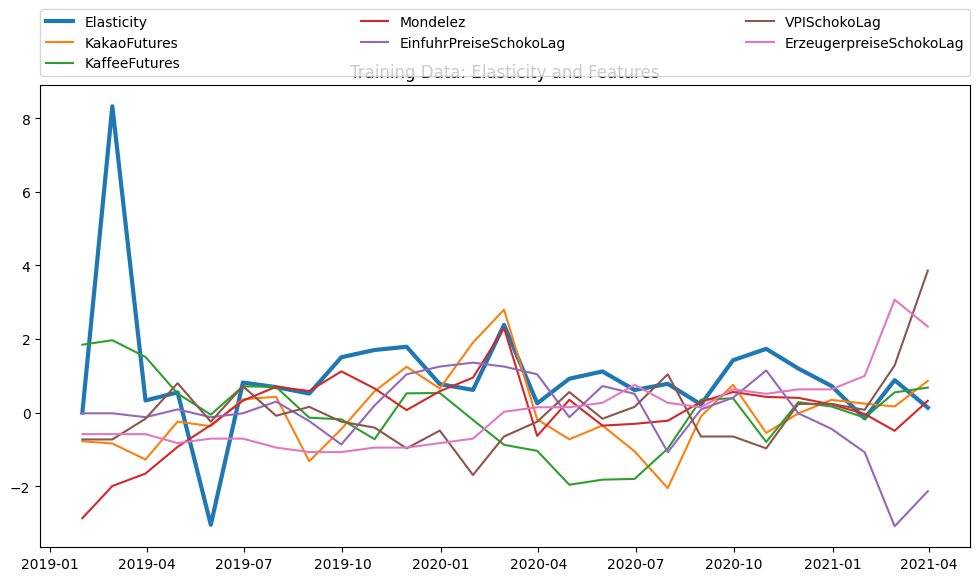

In [7]:
# time series plot of features and target variable for batch 1
plt.figure(figsize=(12, 6))
plt.plot(y_train_1_imputed, label='Elasticity', linewidth=3)
X_train_features = X_train_1_processed_df.columns.tolist()
for feature in X_train_features:
    plt.plot(X_train_1_processed_df[feature], label=feature)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)
plt.title('Training Data: Elasticity and Features') 
plt.show()

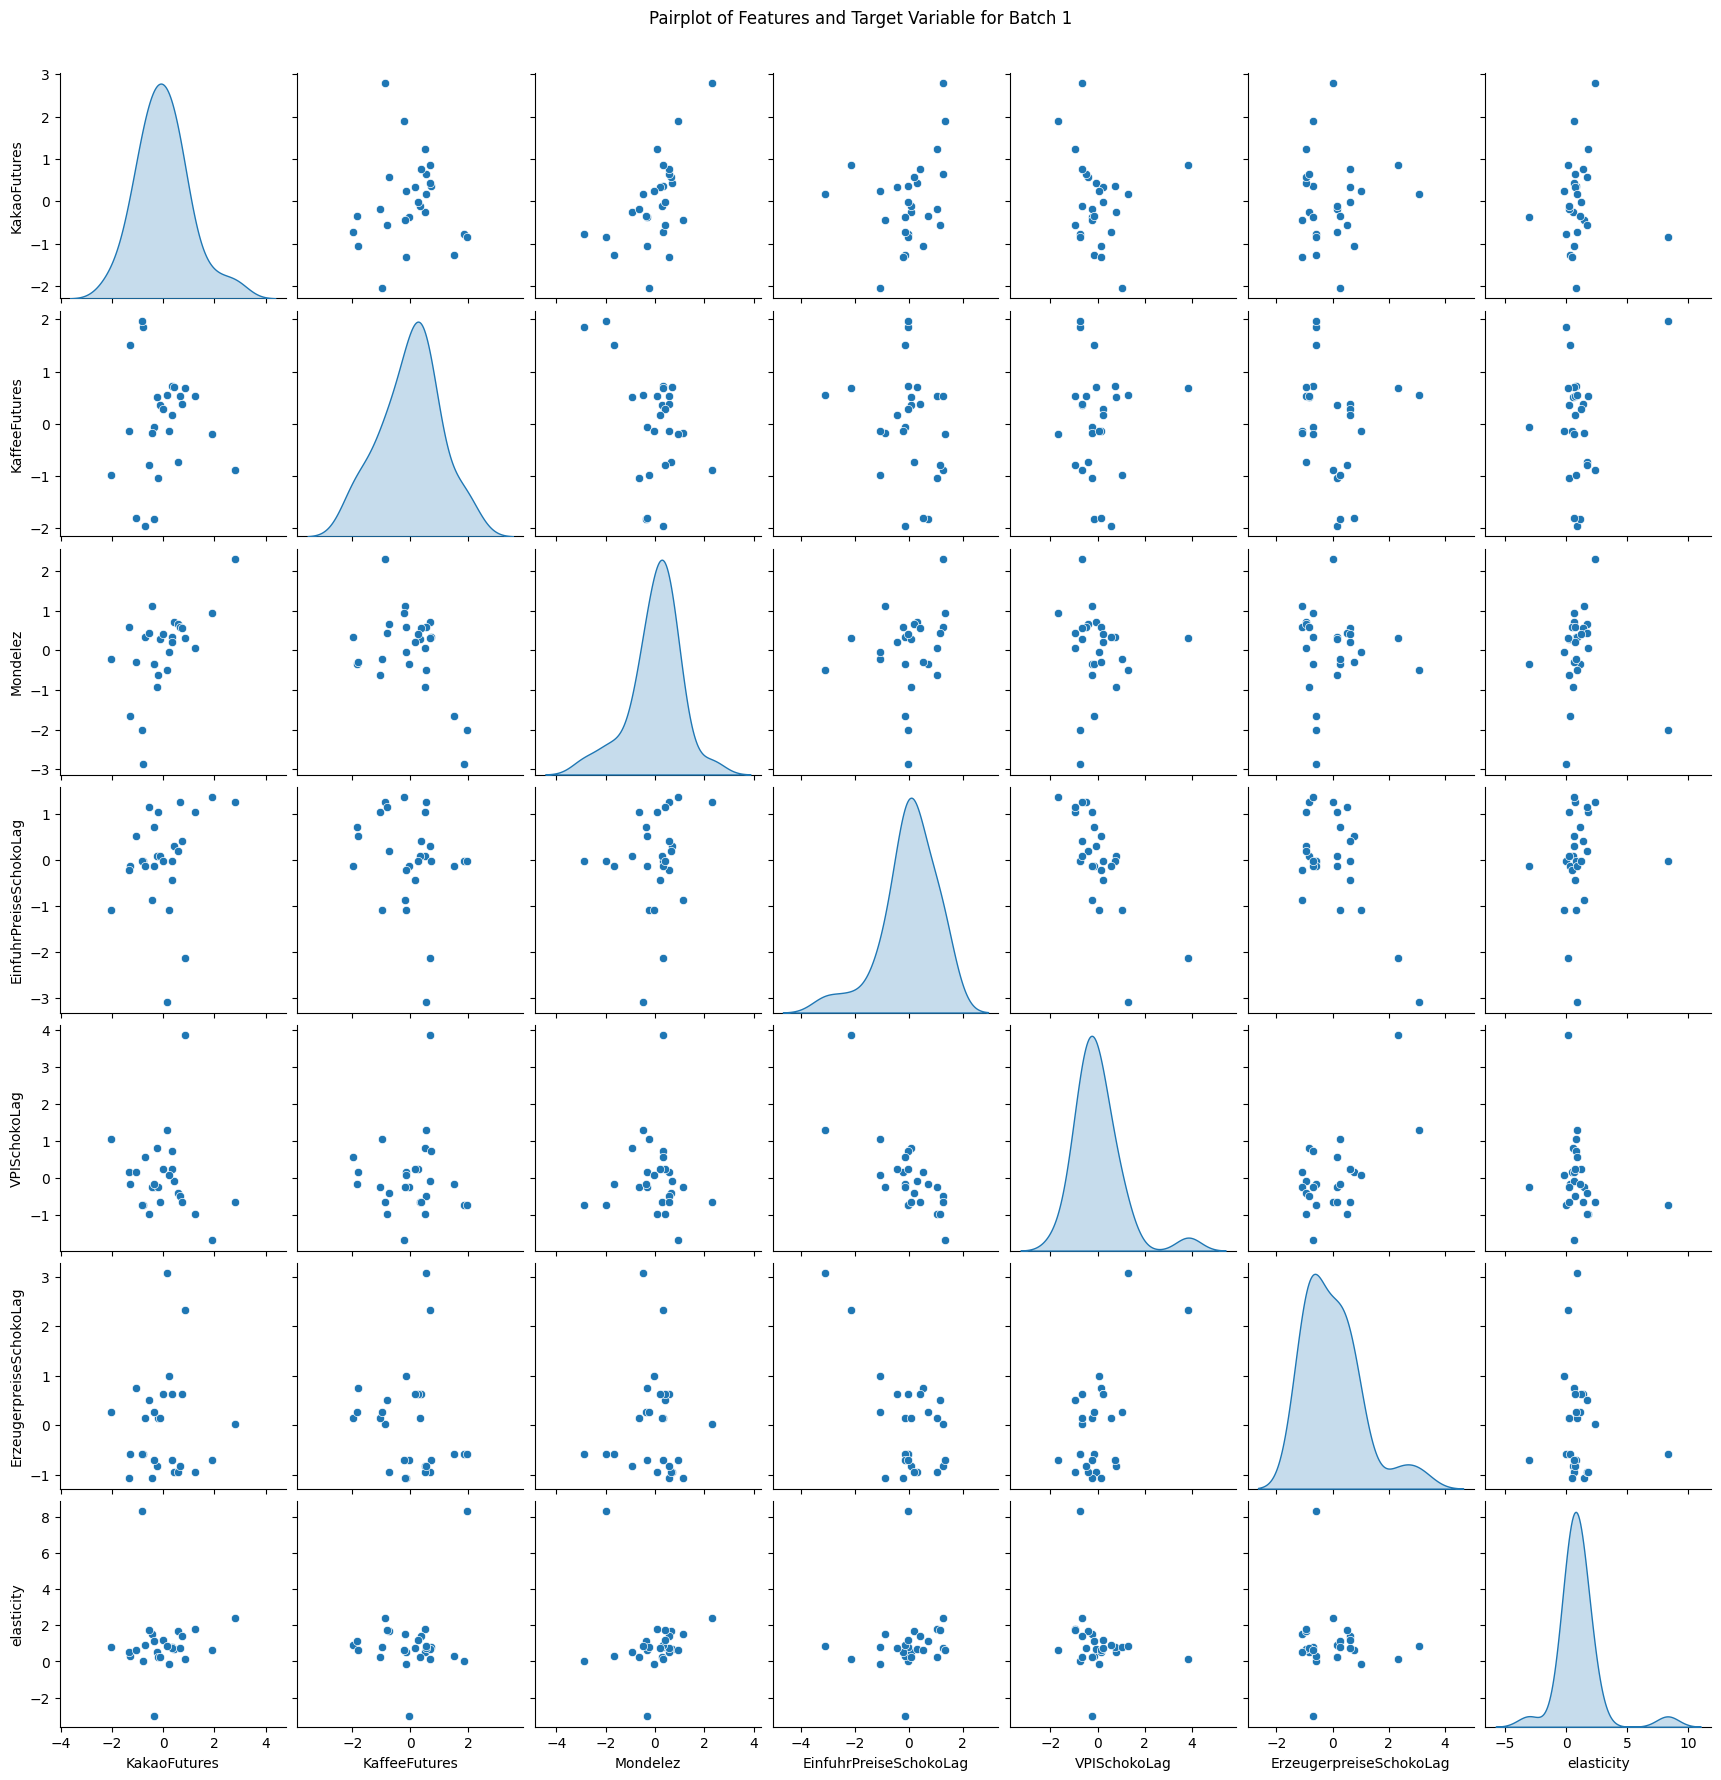

In [11]:
# pairplot of features and target variable for batch 1
sns.pairplot(pd.concat([X_train_1_processed_df, y_train_1_imputed], axis=1), diag_kind='kde')
plt.suptitle('Pairplot of Features and Target Variable for Batch 1', y=1.02)
plt.show()

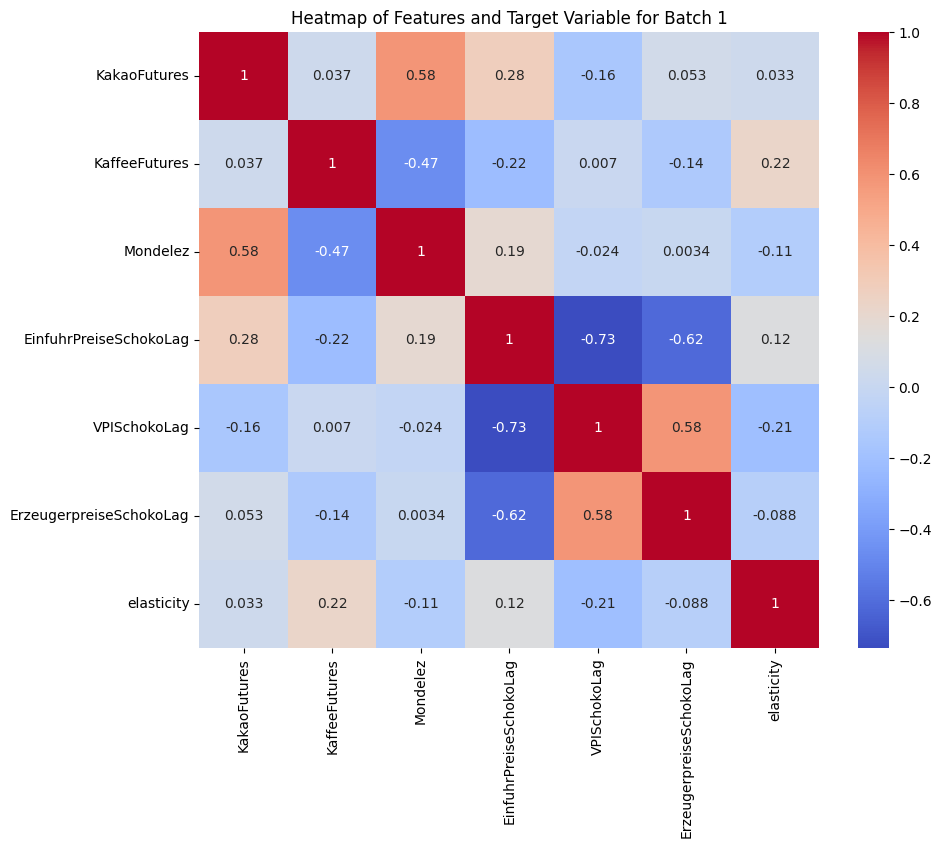

In [18]:
# heatmap of features and target variable for batch 1
plt.figure(figsize=(10, 8))
sns.heatmap(pd.concat([X_train_1_processed_df, y_train_1_imputed], axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Features and Target Variable for Batch 1')
plt.show()

#### EDA Batch 2

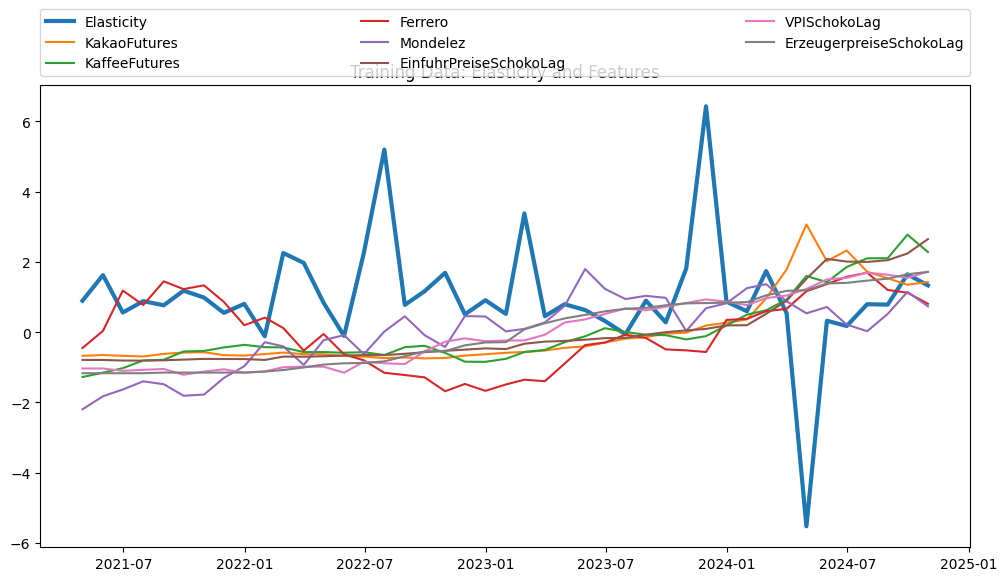

In [12]:
# time series plot of features and target variable for batch 2
plt.figure(figsize=(12, 6))
plt.plot(y_train_2_imputed, label='Elasticity', linewidth=3)
X_train_features = X_train_2_processed_df.columns.tolist()
for feature in X_train_features:
    plt.plot(X_train_2_processed_df[feature], label=feature)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.) 
plt.title('Training Data: Elasticity and Features')
plt.show()

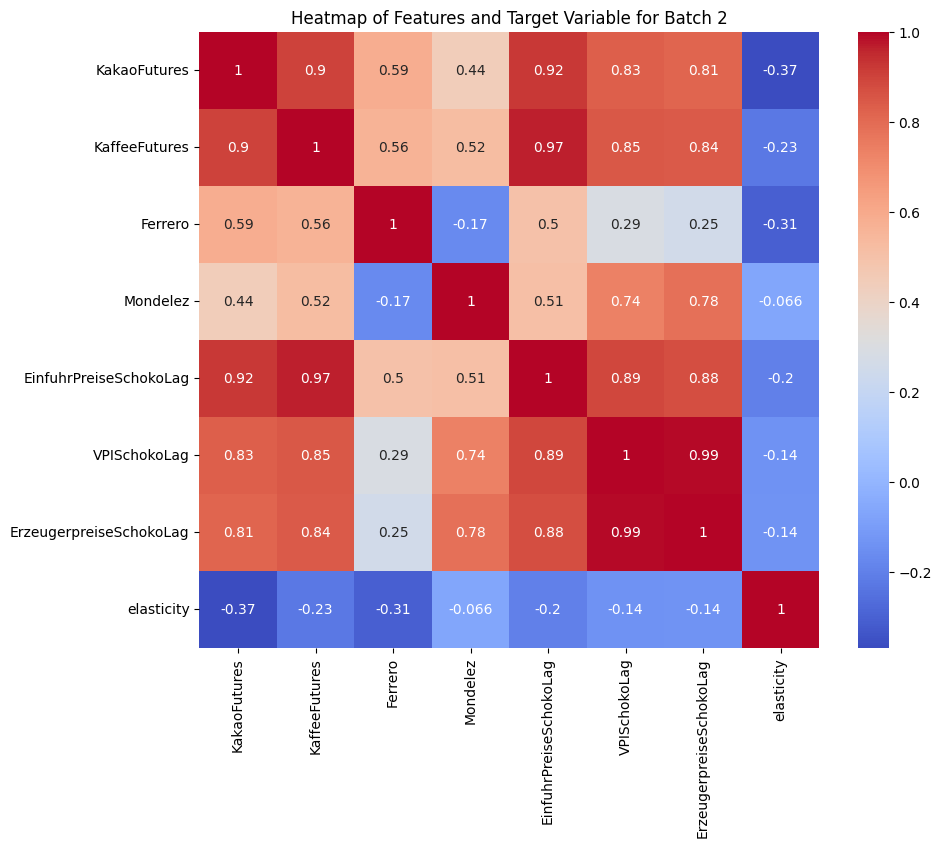

In [14]:
# heatmap of features and target variable for batch 2
df_batch_2 = pd.concat([X_train_2_processed_df, y_train_2_imputed], axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(df_batch_2.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Features and Target Variable for Batch 2')
plt.show()

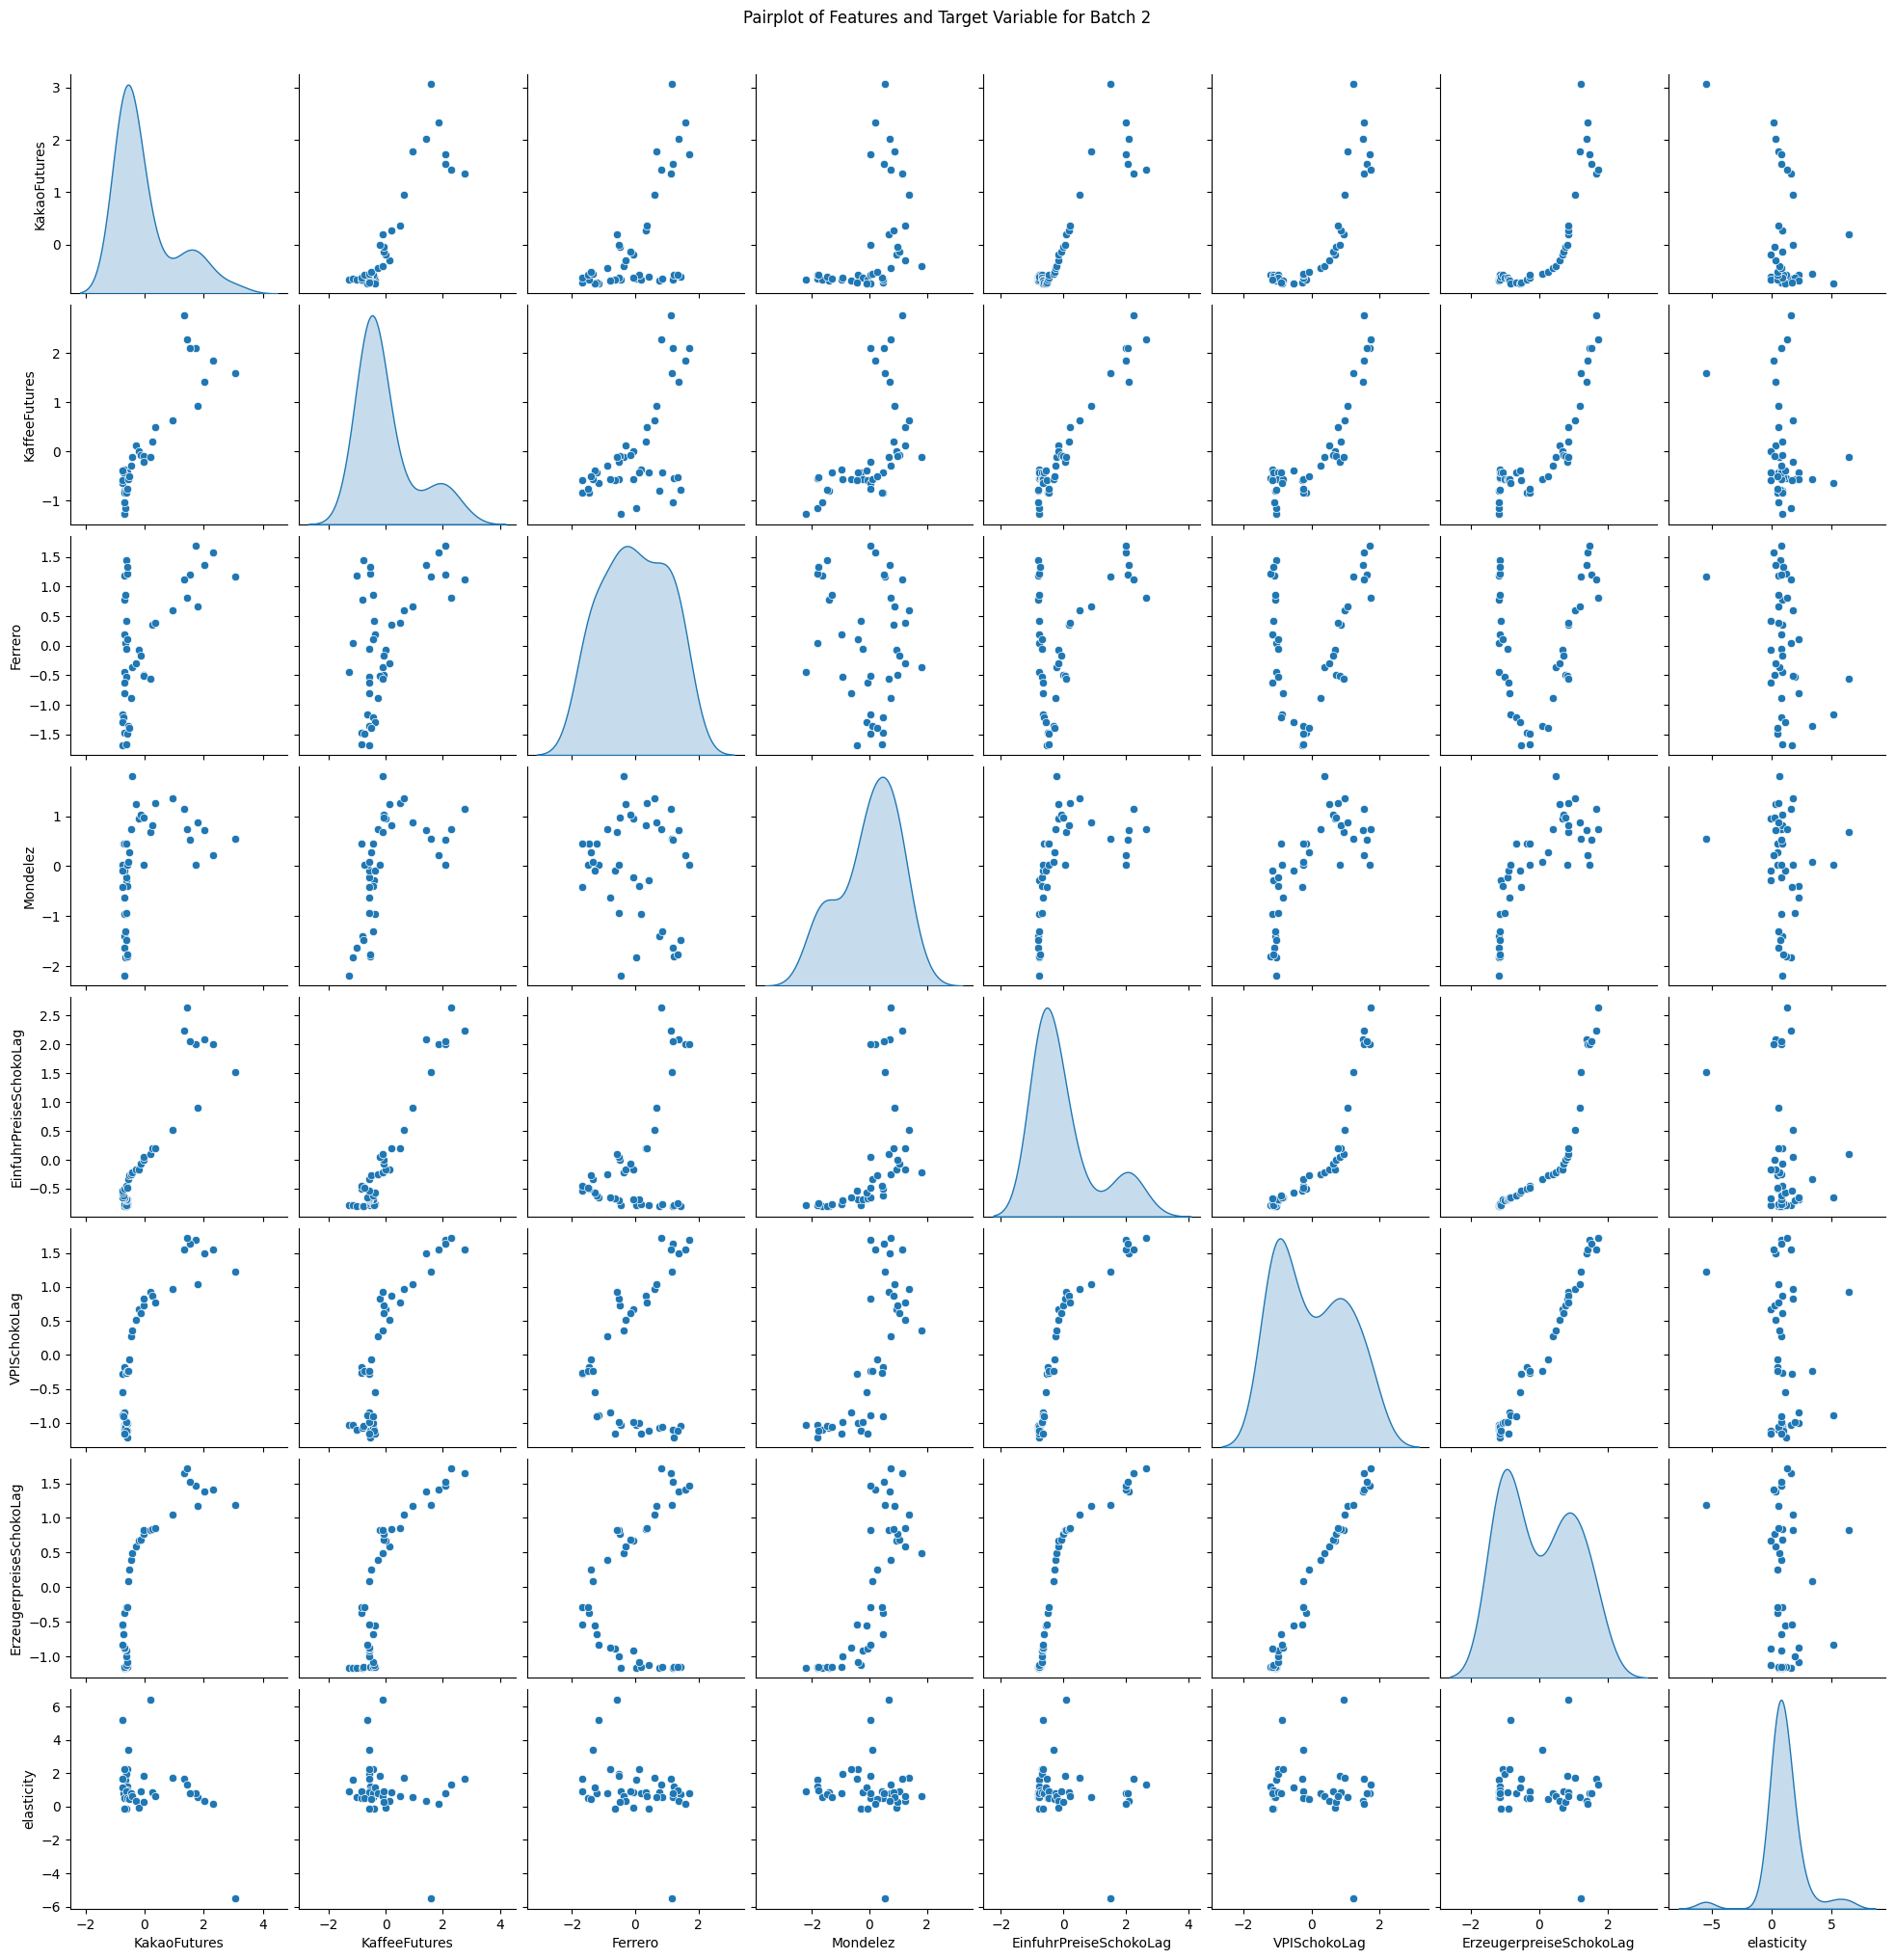

In [15]:
# pairplot of features and target variable for batch 2
sns.pairplot(pd.concat([X_train_2_processed_df, y_train_2_imputed], axis=1), diag_kind='kde')
plt.suptitle('Pairplot of Features and Target Variable for Batch 2', y=1.02)
plt.show()

#### EDA Batch 3

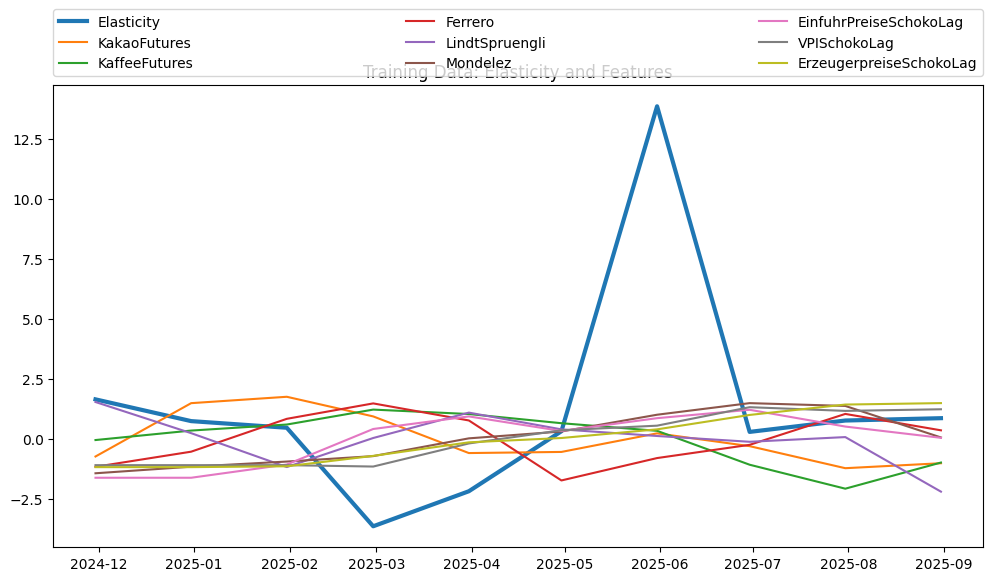

In [13]:
# time series plot of features and target variable for batch 3
plt.figure(figsize=(12, 6))
plt.plot(y_train_3_imputed, label='Elasticity', linewidth=3)
X_train_features = X_train_3_processed_df.columns.tolist()
for feature in X_train_features:
    plt.plot(X_train_3_processed_df[feature], label=feature)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)
plt.title('Training Data: Elasticity and Features')
plt.show()

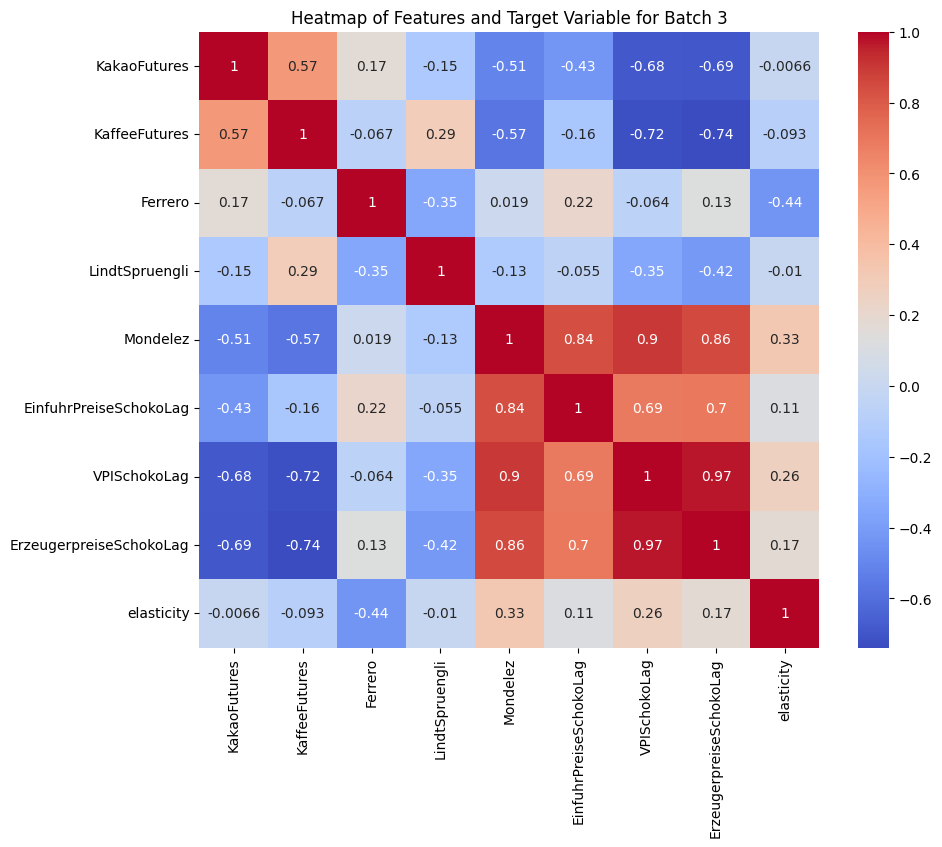

In [16]:
# heatmap of features and target variable for batch 3
df_batch_3 = pd.concat([X_train_3_processed_df, y_train_3_imputed], axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(df_batch_3.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Features and Target Variable for Batch 3')
plt.show()

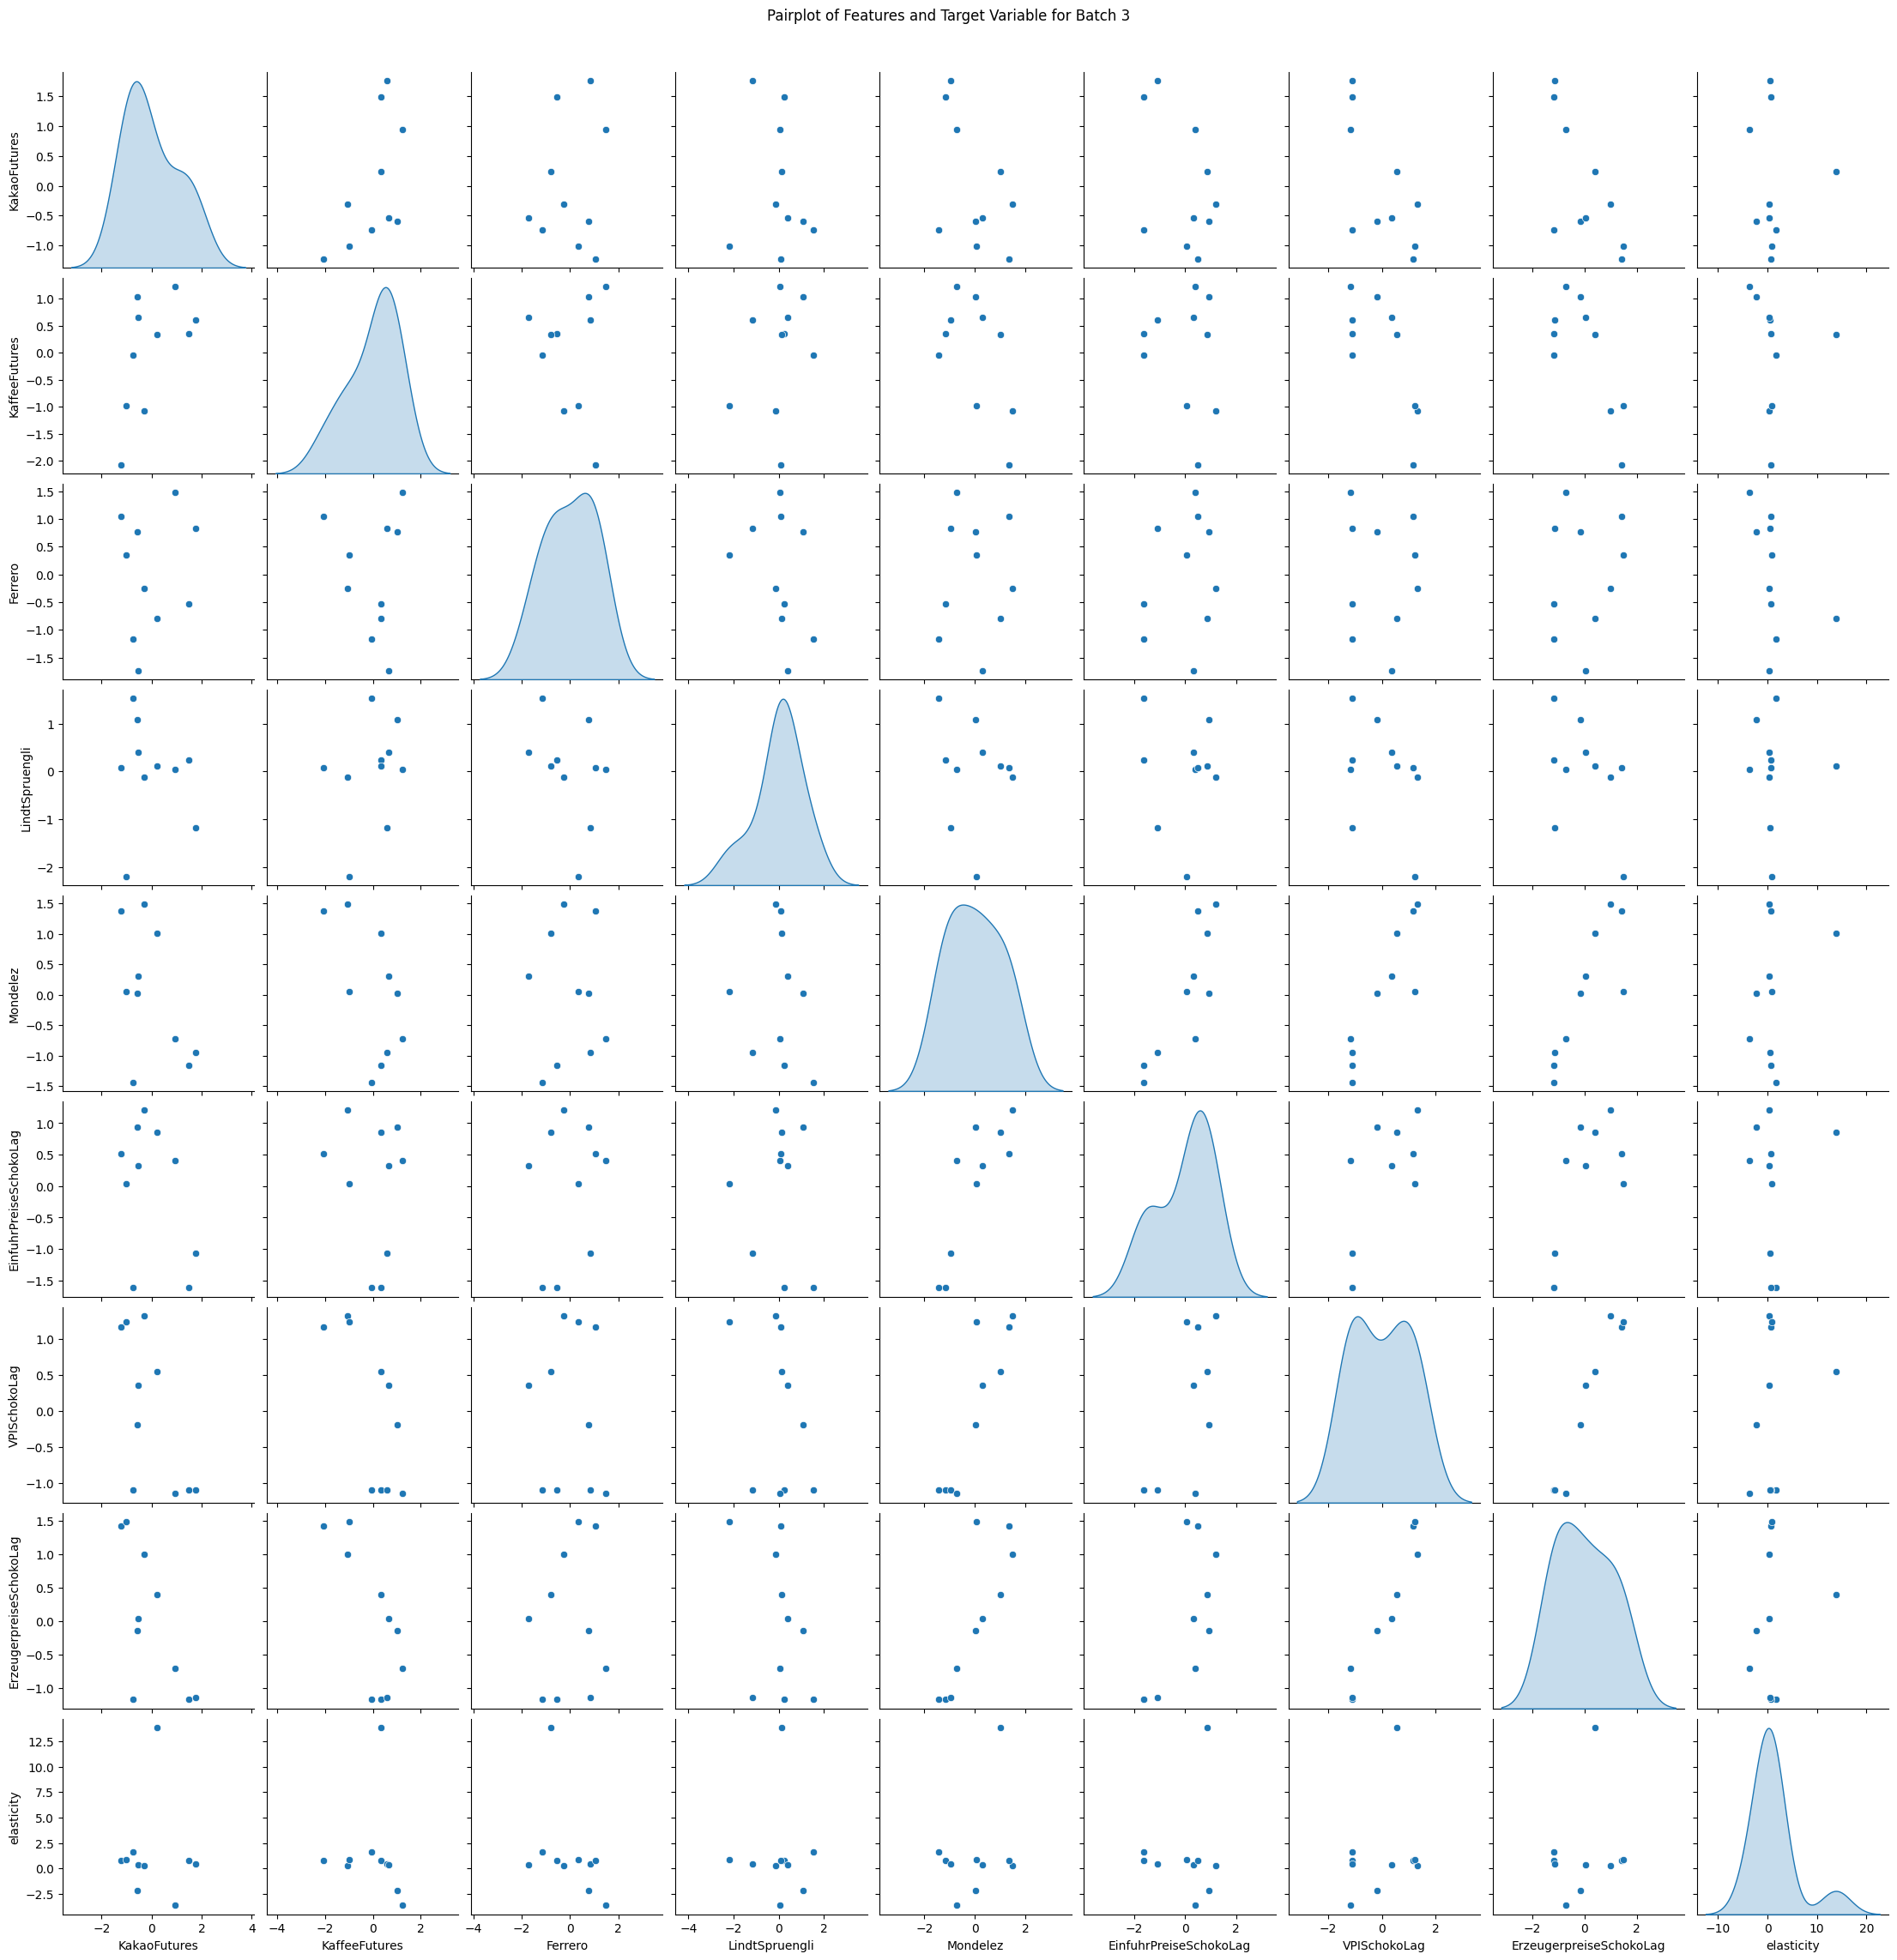

In [17]:
# pairplot of features and target variable for batch 3 
sns.pairplot(pd.concat([X_train_3_processed_df, y_train_3_imputed], axis=1), diag_kind='kde')
plt.suptitle('Pairplot of Features and Target Variable for Batch 3', y=1.02)
plt.show()

## Training and Evaluation

In [6]:
# training and evaluating XGBoost model
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore") # ignoring warnings for cleaner output

In [11]:
# training XGBoost in for loop

batches = [(X_train_1_processed_df, y_train_1_imputed, X_test_1_processed_df, y_test_1),
           (X_train_2_processed_df, y_train_2_imputed, X_test_2_processed_df, y_test_2),
           (X_train_3_processed_df, y_train_3_imputed, X_test_3_processed_df, y_test_3)]

for i, (X_train, y_train, X_test, y_test) in enumerate(batches):
    # initiating and fitting XGBoost model
    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    # saving model for later use in prediction and plotting
    globals()[f'model_{i}'] = model
    # making predictions and evaluating model performance
    y_pred = model.predict(X_test)
    mre = [np.mean(np.abs((y_test[:j+1] - y_pred[:j+1]) / y_test[:j+1])) for j in range(len(y_test))]
    mae = [mean_absolute_error(y_test[:j+1], y_pred[:j+1]) for j in range(len(y_test))]
    r2 = r2_score(y_test, y_pred)
    y_pred_df = pd.DataFrame({
    'Actual': y_test, 'Prediction': y_pred, 'Mean_Relative_Error': mre, 'Mean_Absolute_Error': mae, 'R2_Score': r2
    }, index=y_test.index)
    # saving predictions and evaluation metrics for later use in plotting
    globals()[f'y_pred_df_{i}'] = y_pred_df

    

In [25]:
# all batches in one dataframe for comparison
y_pred_df_all = pd.concat([y_pred_df_0, y_pred_df_1, y_pred_df_2], axis=0)
y_pred_df_all

,Actual,Prediction,Mean_Relative_Error,Mean_Absolute_Error,R2_Score
Datum,,,,,
2020-12-31,0.723624,0.703789,0.027411,0.019835,0.999451
2021-01-31,-0.158603,-0.158050,0.015450,0.010194,0.999451
2021-02-28,0.880079,0.879604,0.010480,0.006954,0.999451
2021-03-31,0.133023,0.133659,0.009056,0.005375,0.999451
2024-07-31,0.796324,0.795721,0.000757,0.000603,0.999997
2024-08-31,0.784604,0.785660,0.001051,0.000829,0.999997
2024-09-30,1.646908,1.646499,0.000784,0.000689,0.999997
2024-10-31,1.331671,1.331481,0.000623,0.000565,0.999997
2025-08-31,0.861298,0.861329,0.000037,0.000032,-0.579789


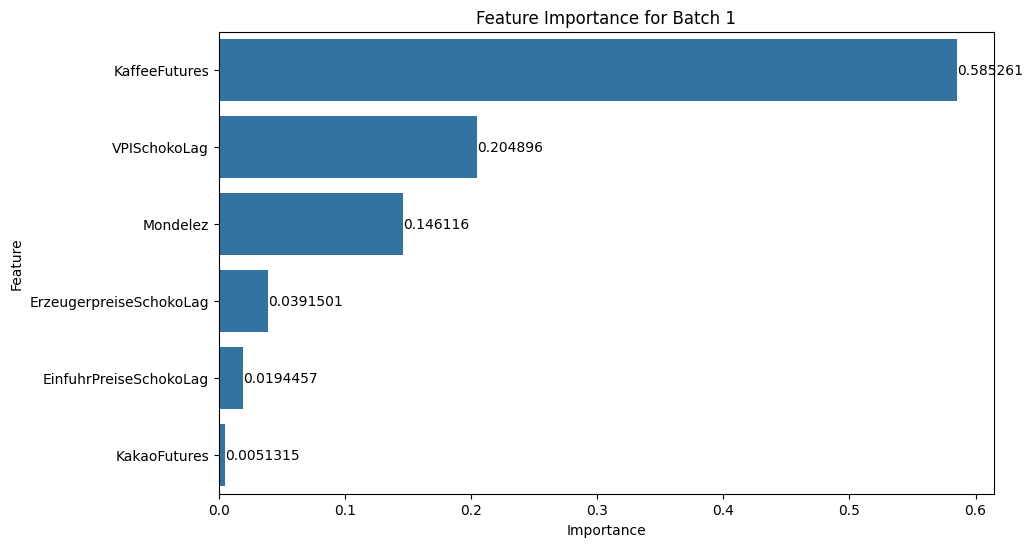

In [24]:
# feature importance plot for batch 1 with feature importance values from XGBoost model trained on batch 1
importances_1 = model_0.feature_importances_
feature_names_1 = X_train_1_processed_df.columns
feature_importance_df_1 = pd.DataFrame({'Feature': feature_names_1, 'Importance': importances_1})
feature_importance_df_1 = feature_importance_df_1.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df_1)
ax.bar_label(ax.containers[0], label_type='edge')
plt.title('Feature Importance for Batch 1')
plt.show()

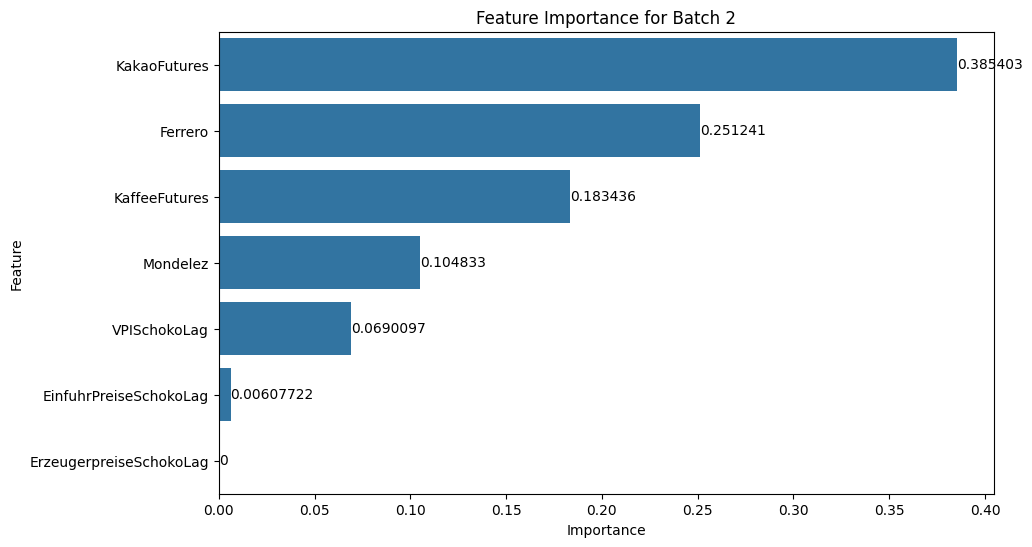

In [26]:
# feature importance plot for batch 2
importances_2 = model_1.feature_importances_
feature_names_2 = X_train_2_processed_df.columns
feature_importance_df_2 = pd.DataFrame({'Feature': feature_names_2, 'Importance': importances_2})
feature_importance_df_2 = feature_importance_df_2.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2)
ax.bar_label(ax.containers[0], label_type='edge')
plt.title('Feature Importance for Batch 2')
plt.show()

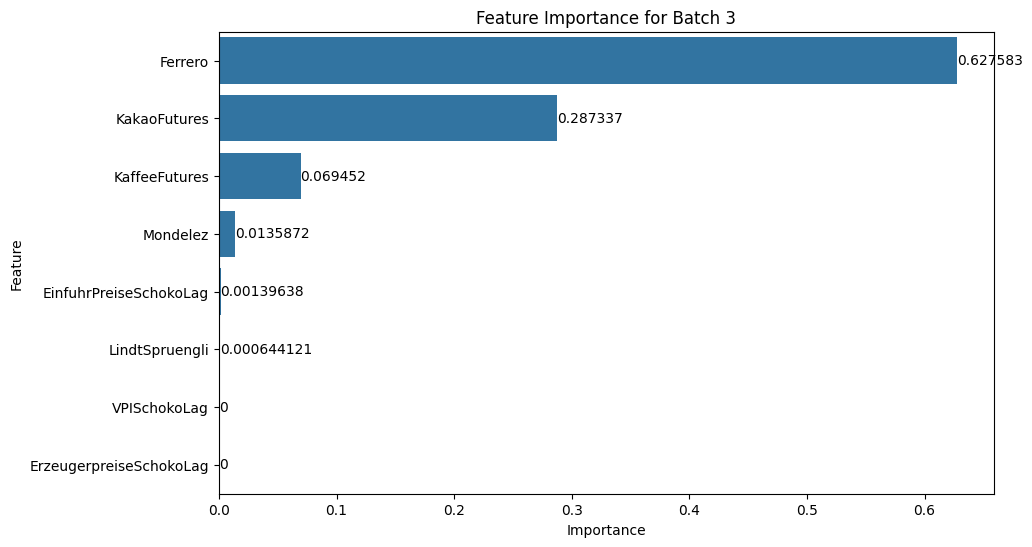

In [27]:
# feature importance plot for batch 3
importances_3 = model_2.feature_importances_
feature_names_3 = X_train_3_processed_df.columns
feature_importance_df_3 = pd.DataFrame({'Feature': feature_names_3, 'Importance': importances_3})
feature_importance_df_3 = feature_importance_df_3.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df_3)
ax.bar_label(ax.containers[0], label_type='edge')
plt.title('Feature Importance for Batch 3')
plt.show()